# **Tarea 4 - Sequence to Sequence 📚**

**Procesamiento de Lenguaje Natural (CC6205-1 - Otoño 2024)**

## Tarjeta de identificación

**Nombres:** Jorge Cruces y Camila Reyes

**Fecha límite de entrega 📆:** 10/07.

**Tiempo estimado de dedicación:** 4 horas


## Instrucciones

Bienvenid@s a la tercera tarea en el curso de Natural Language Processing (NLP). Esta tarea tiene como objetivo evaluar los contenidos teóricos de las últimas semanas de clases posteriores a la Tarea 3, enfocado en **Sequence-to-Sequence + Attention**. Si aún no has visto las clases, se recomienda visitar los links de las referencias.

* La tarea es en **grupo** (maximo hasta 3 personas).
* La entrega es a través de u-cursos a más tardar el día estipulado arriba.
* El formato de entrega es este mismo Jupyter Notebook.
* Al momento de la revisión su código será ejecutado. Por favor verifiquen que su entrega no tenga errores de compilación.
* Completar la tarjeta de identificación. Sin ella no podrá tener nota.
* Recomendamos mirar el enunciado completo con atención (*ba dum tss*) antes de empezar la tarea, para tener una idea más completa de lo que se pide.

## Material de referencia

Diapositivas del curso 📄
    
- [Sequence-to-Sequence + Attention](https://github.com/dccuchile/CC6205/blob/master/slides/NLP-seq2seq.pdf)
- [Transformer](https://github.com/dccuchile/CC6205/blob/master/slides/NLP-transformer.pdf)

Videos del curso 📺

- [Sequence-to-Sequence + Attention](https://www.youtube.com/watch?v=OpKxRjISqmM&list=PLppKo85eGXiXIh54H_qz48yHPHeNVJqBi&index=35)
- [Transformer](https://www.youtube.com/watch?v=8RE23Uq8rU0)

## Parte 1: Traducción automática con arquitectura Encoder-Decoder con RNNs
En esta sección crearemos nuestro propio traductor de español a inglés con la arquitecura Encoder-Decoder con RNNs + Attention vista en clases.

In [1]:
## Importamos librerías

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

### P0. Preparación del dataset y tokenización

Utilizaremos un dataset de pares de oraciones en inglés y castellano.

In [2]:
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip

--2024-07-11 00:37:19--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5420295 (5.2M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.17M  16.3MB/s    in 0.3s    

2024-07-11 00:37:19 (16.3 MB/s) - ‘spa-eng.zip’ saved [5420295/5420295]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


Vamos a crear una clase que nos permita procesar mejor cada idioma del corpus. Esto nos será útil para manejar dos vocabularios distintos.

In [3]:
# Código base

SOS_token = 0
EOS_token = 1
MAX_LENGTH = 5 # Utilizamos 5 por temas de rendimiento

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "*", 1: "STOP"}
    self.n_tokens = 2  # * y STOP

  def add_sentence(self, sentence):
    for word in sentence.split(' '):
      self.add_word(word)

  def add_word(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_tokens
      self.word2count[word] = 1
      self.index2word[self.n_tokens] = word
      self.n_tokens += 1
    else:
      self.word2count[word] += 1

Implemente acá funciones para leer, procesar y filtar el dataset según estime.

In [4]:
# Minúsculas, puntuación y remoción de caracteres que no son letras
# Puede añadir cualquier otro preprocesamiento que estime conveniente
def normalize_string(s):
  s = unicodedata.normalize('NFC', s) # Normalización de caracteres unicode
  s = s.lower().strip()
  s = re.sub(r"([.!?])", r" \1", s) # Regex para separar puntuación de las palabras
  s = re.sub(r"[^a-zA-Z!?áéíóúñ´]+", r" ", s) # Regex para excluir otros caracteres
  return s.strip()

# Recomendamos mantener sólo oraciones con ~10 palabras o menos
def filter_pairs(pairs, max_length):
  return [p for p in pairs if len(p[0].split(' ')) < max_length and \
                len(p[1].split(' ')) < max_length]

In [5]:
def read_dataset(path, reverse=False):
  lines = open(path, encoding='utf-8').\
    read().strip().split('\n')

  pairs = [[normalize_string(s) for s in l.split('\t')][:2] for l in lines]

  # Reverse pairs, make Lang instances
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang("spa")
    output_lang = Lang("eng")
  else:
    input_lang = Lang("eng")
    output_lang = Lang("spa")

  return input_lang, output_lang, pairs

def read_langs(lang1, lang2, reverse=False, max_length=10):
  input_lang, output_lang, pairs = read_dataset("spa.txt", reverse)
  print(f"Total de oraciones en dataset: {len(pairs)}")
  pairs = filter_pairs(pairs, max_length)
  print(f"Reducido a: {len(pairs)}")
  for pair in pairs:
    input_lang.add_sentence(pair[0])
    output_lang.add_sentence(pair[1])
  print(f"Tamaño vocab {input_lang.name}: {input_lang.n_tokens}")
  print(f"Tamaño vocab {output_lang.name}: {output_lang.n_tokens}")
  return input_lang, output_lang, pairs

In [6]:
input_lang, output_lang, pairs = read_langs('eng', 'spa', reverse=True, max_length=5)
print(random.choice(pairs))

Total de oraciones en dataset: 141543
Reducido a: 24011
Tamaño vocab spa: 9688
Tamaño vocab eng: 5376
['parecen felices', 'they seem happy']


### P1. Encoder (1.2 pt.)
Implemente una red Encoder utilizando redes neuronales recurrentes.

In [7]:
# Garantizar reproducibilidad de los experimentos
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### P2. Attention Decoder (1.8 pt.)

Ahora diseñe un mecanismo de atención según estime conveniente y otra red que servirá de decoder con el modelo de attention. Utilice la predicción objetivo (en caso de existir) como siguiente input de cada oración para la etapa de entrenamiento (teacher forcing).

In [9]:
class MyAttention(nn.Module):
    def __init__(self, hidden_size):
        super(MyAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights



class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = MyAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Aqui obtenemos el target input en caso ed existir
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Si no tenemos Teacher forcing usamos las mismas predicciones como el mismo input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

Aqui utilizamos la atención Bahdanau, también conocida como atención aditiva, es un mecanismo de atención comúnmente utilizado en modelos de secuencia a secuencia, particularmente en tareas de traducción automática neural.









### P3. Entrenamiento y evaluación (1 pt.)
Entrene su modelo Sequence-to-Sequence. Para esto entrene el encoder, decoder y attention en conjunto, es decir utilizando la misma función de loss para los parámetros de cada componente. Recuerde entregar las predicciones objetivo al decoder en cada iteración.

In [10]:
import math
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [11]:
def sentence2indexes(lang, sentence):
  return [lang.word2index[word] for word in sentence.split(' ')]

def sentence2tensor(lang, sentence):
  indexes = sentence2indexes(lang, sentence)
  indexes.append(EOS_token)
  return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def pair2tensors(pair):
  input_tensor = sentence2tensor(input_lang, pair[0])
  target_tensor = sentence2tensor(output_lang, pair[1])
  return (input_tensor, target_tensor)


def get_dataloader(batch_size):
  input_lang, output_lang, pairs = read_langs('eng', 'spa', reverse=True, max_length=5) # Lo dejamos en 5 para que no supere el limite de la RAM del collab

  n = len(pairs)
  input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
  target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

  for idx, (inp, tgt) in enumerate(pairs):
      inp_ids = sentence2indexes(input_lang, inp)
      tgt_ids = sentence2indexes(output_lang, tgt)
      inp_ids.append(EOS_token)
      tgt_ids.append(EOS_token)
      input_ids[idx, :len(inp_ids)] = inp_ids
      target_ids[idx, :len(tgt_ids)] = tgt_ids

  print("Train data preparada")
  train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                              torch.LongTensor(target_ids).to(device))

  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  return input_lang, output_lang, train_dataloader


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
device

device(type='cuda')

In [14]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
import time
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Esto para que plotee dentro del colab
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points, label="Perdida a través de las épocas")
    plt.legend()
    plt.show()


In [17]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=100, plot_every=100):
  start = time.time()
  plot_losses = []
  print_loss_total = 0
  plot_loss_total = 0

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  criterion = nn.NLLLoss()

  for epoch in range(1, n_epochs + 1):
      print(f"Entrando a entrenar Epoca: {epoch}")
      loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
      print_loss_total += loss
      plot_loss_total += loss

      if epoch % print_every == 0:
          print_loss_avg = print_loss_total / print_every
          print_loss_total = 0
          print('%s (Época %d, %d%% completado) Pérdida Promedio: %.4f' % (
              time_since(start, epoch / n_epochs),
              epoch, epoch / n_epochs * 100, print_loss_avg))

      if epoch % plot_every == 0:
          plot_loss_avg = plot_loss_total / plot_every
          plot_losses.append(plot_loss_avg)
          plot_loss_total = 0

  show_plot(plot_losses)


Aqui probamos con un número de épocas y un batch_size bastante reducido más que nada por el tiempo que demora en entrenar el modelo. Además utilizamos un tamaño máximo de las sentencias del vocabulario de 5 por la misma razón, es decir, para que no demore tanto entrenamiento.

In [18]:
hidden_size = 128
batch_size = 16
epochs = 30
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_tokens, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_tokens).to(device)


Total de oraciones en dataset: 141543
Reducido a: 24011
Tamaño vocab spa: 9688
Tamaño vocab eng: 5376
Train data preparada


Entrando a entrenar Epoca: 1
Entrando a entrenar Epoca: 2
Entrando a entrenar Epoca: 3
Entrando a entrenar Epoca: 4
Entrando a entrenar Epoca: 5
1m 29s (- 7m 28s) (Época 5, 16% completado) Pérdida Promedio: 2.0750
Entrando a entrenar Epoca: 6
Entrando a entrenar Epoca: 7
Entrando a entrenar Epoca: 8
Entrando a entrenar Epoca: 9
Entrando a entrenar Epoca: 10
2m 56s (- 5m 52s) (Época 10, 33% completado) Pérdida Promedio: 0.7358
Entrando a entrenar Epoca: 11
Entrando a entrenar Epoca: 12
Entrando a entrenar Epoca: 13
Entrando a entrenar Epoca: 14
Entrando a entrenar Epoca: 15
4m 22s (- 4m 22s) (Época 15, 50% completado) Pérdida Promedio: 0.3527
Entrando a entrenar Epoca: 16
Entrando a entrenar Epoca: 17
Entrando a entrenar Epoca: 18
Entrando a entrenar Epoca: 19
Entrando a entrenar Epoca: 20
5m 54s (- 2m 57s) (Época 20, 66% completado) Pérdida Promedio: 0.2218
Entrando a entrenar Epoca: 21
Entrando a entrenar Epoca: 22
Entrando a entrenar Epoca: 23
Entrando a entrenar Epoca: 24
Entrando a

<Figure size 640x480 with 0 Axes>

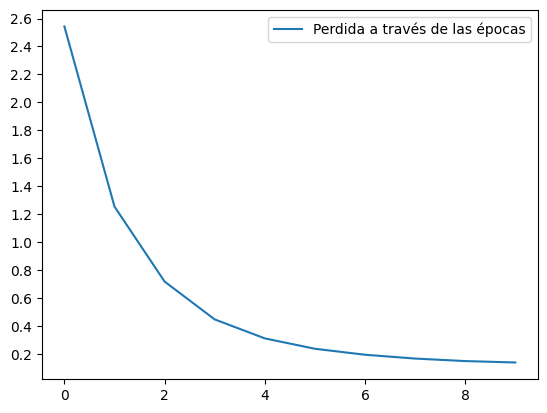

In [19]:
train(train_dataloader, encoder, decoder, epochs, print_every=5, plot_every=3)

**Comente sus resultados. ¿Cómo evoluciona la loss a medida que aumenta el número de epochs?**


En esta arquitectura Encoder-Decoder con RNNs y atención, la loss disminuye a medida que aumenta el número de épocas, como se observa en el gráfico adjunto. Durante el entrenamiento, los pesos del modelo se ajustan iterativamente para minimizar la loss, mejorando así las predicciones. El modelo ajusta mejor sus parámetros, aprende de los datos y mejora su capacidad de traducir entre los idiomas, tal como se refleja en la curva descendente del gráfico.







Adapte las siguientes funciones para traducir oraciones con su modelo. Pruebe su traductor con algunas oraciones aleatorias del corpus.




In [39]:
def translate(encoder, decoder, sentence, input_lang, output_lang):
  with torch.no_grad():
    input_tensor = sentence2tensor(input_lang, sentence)

    encoder_outputs, encoder_hidden = encoder(input_tensor)
    decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

    _, topi = decoder_outputs.topk(1)
    decoded_ids = topi.squeeze()

    decoded_words = []


    for idx in decoded_ids[0]: # Aqui consideramos la primera sentencia del batch entero
      if idx.item() == EOS_token:
        decoded_words.append('STOP')
        break
      decoded_words.append(output_lang.index2word[idx.item()])
  return decoded_words, decoder_attn


def evaluate_randomly(encoder, decoder, dataset, n=10):
  for i in range(n):
    pair = random.choice(dataset)
    print('Input:', pair[0])
    print('Traducción:', pair[1])
    output_words, _ = translate(encoder, decoder, pair[0], input_lang, output_lang)
    output_sentence = ' '.join(output_words)
    print('Predicción:', output_sentence)
    print('')

In [88]:
evaluate_randomly(encoder, decoder, pairs, 5)

Input: volví
Traducción: i have returned
Predicción: i m lost lost STOP

Input: te admiraba
Traducción: i admired you
Predicción: you like you STOP

Input: eres ambicioso
Traducción: you re ambitious
Predicción: you are full smart STOP

Input: yo quiero su respeto
Traducción: i want your respect
Predicción: alone chicken experience plays plug

Input: yo casi muero
Traducción: i nearly died
Predicción: alone duty push easy experience



**Comente sus resultados. ¿Qué ocurre con las cuando la traducción predicha es válida pero no igual al ground truth? ¿Qué haría para abordar este problema?**


Cuando la traducción predicha es valida pero no igual al ground truth lo que ocurre es que la traducción del modelo es valida pero no coincide con la traducción de referencia.

Un ejemplo donde esto puede notarse claro es el siguiente:

**Inglés**: "I am a student"

**Ground Truth** --> Español: "Soy un estudiante"

**Predicción del Modelo** --> Español: "Yo soy estudiante

En este caso la predicción del modelo es valida, pero no exactamente lo que buscamos como traducción. Para abordar este problema se deben utilizar métricas de evaluación adecuadas como BLEU, que toleran sinónimos y variaciones en la estructura de las frases. Además es útil incorporar múltiples traducciones válidas en el conjunto de datos de entrenamiento, aplicar técnicas de augmentación de datos para generar paraphrases, y mejorar la arquitectura del modelo con mecanismos de atención o Transformers


### P4. Visualizando Attention (0.5 pt.)

Ahora visualizaremos los pesos de atención asignados entre las palabras traducidas. Para esto, les entregamos funciones para visualizar los pesos de atención entregados por su decoder a partir de una oración. Adapte el código al output de su modelo de ser necesario.

In [89]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

In [27]:
%matplotlib inline

In [125]:
def plot_attention(input_sentence, output_words, attentions):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
  fig.colorbar(cax)

  # Set up axes
  ax.xaxis.set_ticks(attentions)
  ax.set_xticklabels([''] + input_sentence.split(' ') +
             ['STOP'], rotation=90)
  ax.set_yticklabels([''] + output_words)

  # Show label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


def show_attention(input_sentence):
  output_words, attentions = translate(encoder, decoder, input_sentence, input_lang, output_lang)
  print('input =', input_sentence)
  print('output =', ' '.join(output_words))
  plot_attention(input_sentence, output_words, attentions[0, :len(output_words), :])

No pudimos correrlo por este error de la cpu

In [126]:
## Oraciones de ejemplo

show_attention('tom necesita un poco de ayuda')
show_attention('el perro corre rápidamente')

show_attention('el banco le ofreció un alto interés')

show_attention('él toca la flauta el clarinete y el saxofón')

input = tom necesita un poco de ayuda
output = tom tom tom tom tom


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
## Oraciones de ejemplo

show_attention('última tarea del ramo !')

show_attention('')

show_attention('')

Comente sus resultados. ¿Eran lo que esperaba?

No pudimos correrlo por ese error de la cpu

## Parte 2: BERT

Lo primero es instalar las librerías necesarias.

In [ ]:
%%capture
!pip install transformers
from transformers import BertTokenizer, BertForNextSentencePrediction, BertForMaskedLM, BertForQuestionAnswering
import torch

Para las preguntas que siguen, utilizaremos distintas variantes de BERT disponibles en la librería transformers. [Aquí](https://huggingface.co/transformers/model_doc/bert.html) pueden encontrar toda la documentación necesaria. El modelo pre-entrenado a utilizar es "bert-base-uncased" (salvo para question answering).

BERT es un modelo de lenguaje que fue entrenado exhaustivamente sobre dos tareas: 1) Next sentence prediction. 2) Masked language modeling.

### **BertForNextSentencePrediction** (0.5 pt.)

**Pregunta 1:**  Utilizando el modelo BertForNextSentencePrediction de la librería transformers, muestre cual de las 2 oraciones es **más probable** que sea una continuación de la primera. Para esto defina la función $oracion\_mas\_probable$, que recibe el inicio de una frase, las alternativas para continuar esta frase y retorna un string indicando cual de las dos oraciones es más probable.

Por ejemplo:

Initial: "The sky is blue."\
A: "This is due to the shorter wavelength of blue light."\
B: "Chile is one of the world's greatest economies."

Debería retornar "La oración que continúa más probable es A", justificándolo con la evaluación de BERT.



In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def oracion_mas_probable(first,sentA,sentB):
  #Tu implementacion
  encodingA = tokenizer(first, sentA, return_tensors='pt')
  encodingB = tokenizer(first, sentB, return_tensors='pt')


  outputA = model(**encodingA, labels=torch.LongTensor([1]))
  outputB = model(**encodingB, labels=torch.LongTensor([1]))

  logitsA = outputA.logits
  logitsB = outputB.logits

  # Determinamos la probabilidad con softmax
  probA = torch.softmax(logitsA, dim=1)[0][0].item()
  probB = torch.softmax(logitsB, dim=1)[0][0].item()

  # print(probA)
  # print(probB)

  if probA > probB:
    return "La oración que continúa más probable es A"
  else:
    return "La oración que continúa más probable es B"

1.1)
Initial: "My cat is fluffy."\
A: "My dog has a curling tail."\
B: "A song can make or ruin a person’s day if they let it get to them."

In [ ]:
initial = "My cat is fluffy."
sentA = "My dog has a curling tail."
sentB = "A song can make or ruin a person’s day if they let it get to them."

oracion_mas_probable(initial, sentA, sentB)

'La oración que continúa más probable es A'

1.2)
Initial: "The Big Apple is famous worldwide."\
A: "You can add cinnamon for the perfect combination."\
B: "It is America's largest city."

In [ ]:
initial2 = "The Big Apple is famous worldwide."
sentA2 = "You can add cinnamon for the perfect combination."
sentB2 = "It is America's largest city."

oracion_mas_probable(initial2, sentA2, sentB2)

'La oración que continúa más probable es B'

1.3)
Initial: "Roses are red."\
A: "Violets are blue."\
B: "Fertilize them regularly for impressive flowers."

In [ ]:
initial3 = "Roses are red."
sentA3 = "Violets are blue."
sentB3 = "Fertilize them regularly for impressive flowers."

oracion_mas_probable(initial3, sentA3, sentB3)

'La oración que continúa más probable es A'

1.4)
Initial: "I play videogames the whole day."\
A: "They make me happy."\
B: "They make me rage."\

In [ ]:
initial4 = "I play videogames the whole day."
sentA4 = "They make me happy."
sentB4 = "They make me rage."

oracion_mas_probable(initial, sentA, sentB)

'La oración que continúa más probable es A'

Esta función determina cuál de dos oraciones (sentA o sentB) es más probable que siga a una oración inicial (initial). Como se puede ver en los ejemplos de uso, todas las oraciones elegidas por el modelo son las que más tienen sentido. Por lo que concluimos que ayuda a seleccionar la continuación más lógica y coherente para una oración dada.

### **BertForMaskedLM** (0.5 pt.)

**Pregunta 2:**  Ahora utilizaremos BertForMaskedLM para **predecir una palabra oculta** en una oración.\
Por ejemplo:\
BERT input: "I want to _ a new car."\
BERT prediction: "buy"

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

In [ ]:
def palabra_mas_probable(sentence):
  #Tu implementacion
  tokenized_text = tokenizer.tokenize(sentence)
  masked_index = tokenized_text.index('[MASK]')
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])

  segments_tensors = None

  predictions = model(tokens_tensor, segments_tensors).logits

  predicted_index = torch.argmax(predictions[0, masked_index]).item()
  predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]

  return predicted_token

2.1)
BERT input: "[CLS] I love [MASK] . [SEP]"

In [ ]:
sent = "[CLS] I love [MASK] . [SEP]"
palabra_mas_probable(sent)

'you'

2.2)
BERT input: "[CLS] I hear that Karen is very [MASK] . [SEP]"

In [ ]:
sent = "[CLS] I heard that Karen is very [MASK] . [SEP]"
palabra_mas_probable(sent)

'upset'

2.3)
BERT input: "[CLS] She had the gift of being able to [MASK] . [SEP]"

In [ ]:
sent = "[CLS] She had the gift of being able to [MASK] . [SEP]"
palabra_mas_probable(sent)

'fly'

2.4)
BERT input: "[CLS] It's not often you find a [MASK] on the street. [SEP]"

In [ ]:
sent = "[CLS] It's not often you find an [MASK] on the circus . [SEP]"
palabra_mas_probable(sent)

'expert'

Esta función predice una palabra oculta (representada por [MASK]) en una oración usando un modelo BERT para enmascarado de lenguaje. Como se puede ver en los ejemplos de uso, las palabras predichas por el modelo coinciden con las expectativas y el contexto de la oración, lo que concluye que el modelo proporciona resultados satisfactorios en la tarea de predicción de palabras ocultas.

### **BertForQuestionAnswering** (0.5 pt.)

**Pregunta 3**  Utilizando el modelo BertForQuestionAnswering pre-entrenado con 'bert-large-uncased-whole-word-masking-finetuned-squad', **extraiga la respuesta** a cada una de las siguientes 4 preguntas y su contexto. Recuerde cambiar el tokenizer para que coincida con el modelo.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
def entregar_respuesta(qst, cntxt):
  #Tu implementacion
  inputs = tokenizer(qst, cntxt, return_tensors='pt')
  start_positions = torch.tensor([1])
  end_positions = torch.tensor([3])

  outputs = model(**inputs, start_positions=start_positions, end_positions=end_positions)
  start_scores = outputs.start_logits
  end_scores = outputs.end_logits

  # Posiciones de inicio y fin
  start_index = torch.argmax(start_scores)
  end_index = torch.argmax(end_scores) + 1

  all_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
  answer = tokenizer.convert_tokens_to_string(all_tokens[start_index:end_index])

  return answer

3.1)

Pregunta: "When was the Battle of Iquique?"

Contexto: "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."

In [ ]:
q = "When was the Battle of Iquique?"
c = "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."
entregar_respuesta(q, c)

'21 may 1879'

3.2)

Pregunta: "Who won the Battle of Iquique?"

Contexto: "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."

In [ ]:
q = "Who won the Battle of Iquique?"
c = "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."
entregar_respuesta(q, c)

'peruvian'

3.3)

Pregunta: "Who introduced peephole connections to LSTM networks?"
Contexto: "What I’ve described so far is a pretty normal LSTM. But not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them. One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding “peephole connections.” This means that we let the gate layers look at the cell state."

In [ ]:
q = "Who introduced peephole connections to LSTM networks?"
c = "What I’ve described so far is a pretty normal LSTM. But not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them. One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding “peephole connections.” This means that we let the gate layers look at the cell state."
entregar_respuesta(q, c)

'gers & schmidhuber'

3.4)

Pregunta: "When is the cat most active?"

Contexto: "The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-specific body language. It is a solitary hunter but a social species. It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals. It is a predator that is most active at dawn and dusk. It secretes and perceives pheromones."

In [ ]:
q = "When is the cat most active?"
c = "The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-specific body language. It is a solitary hunter but a social species. It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals. It is a predator that is most active at dawn and dusk. It secretes and perceives pheromones."
entregar_respuesta(q, c)

'dawn and dusk'

Esta función extrae la respuesta a una pregunta dada en un contexto utilizando un modelo BERT para preguntas y respuestas. Como se puede ver en los ejemplos de uso, las respuestas extraídas por el modelo son precisas y además coherentes con el contexto proporcionado, lo que concluye que el modelo es efectivo y proporciona resultados satisfactorios en la tarea de respuesta a preguntas.